```
QUERYNAME = CholesterolMSMS;
DEFINE PR = 'C[41..49] H[30..200] O[2] N[1]' WITH DBR = (4.5,10.5), CHG = +1;
DEFINE FR ='C[27] H[45]' WITH DBR = (1,8), CHG = +1;

IDENTIFY

	PR IN MS1+ AND
	FR in MS2+

SUCHTHAT
	(avg(FR.intensity)/avg(PR.intensity) >=0.1 AND avg(FR.intensity)/avg(PR.intensity) <=10) AND
	PR.chemsc[C]/PR.chemsc[db] >= 4.6

REPORT 

	SPECIE = "CE %d:%d" % "((PR.chemsc)[C] - 27, (PR.chemsc)[db] - 4.5)";  
	CLASS = "CE";
	MASS = PR.mass;
	ISOBARIC = PR.isobaric;
	CHEMSC = PR.chemsc;
	ERRppm = "%2.2f" % "(PR.errppm)";
	FRERRppm = "%2.2f" % "(FR.errppm)";
	INT = FR.intensity;
	QUALA = PR.intensity;
```

In [1]:
from targets import MFQL_util
from MS_reader import SpectraUtil

In [2]:
QUERYNAME = 'CholesterolMSMS'

In [3]:
elements = {'C':(41,49),'H':(30,200),'O':(2,2),'N':(1,1),'P':(1,1) }      
PR = MFQL_util(elements)
PR.set_dbr(4.5,10.5)

In [4]:
elements = {'C':(27,27),'H':(45,45) }      
FR = MFQL_util(elements)
FR.set_dbr(1,8)

In [5]:
FR._df.chem

0    C27 H45
Name: chem, dtype: object

In [6]:
filename = '..\\test_resources\\small_test\\190321_Serum_Lipidextract_368723_01.mzML'
spectraUtil = SpectraUtil.fromFile(filename, test_sample=True)

In [7]:
MS1 = spectraUtil
MS2 = spectraUtil.get_reset_copy()
MS1.set_mode()
MS1.set_ms_level()
MS2.set_mode()
MS2.set_ms_level(2)


a copy of the original with nothing set... sorry no undo
set mode to positive : True, (false means negative) 
set ms level to  : 1
set mode to positive : True, (false means negative) 
set ms level to  : 2


In [8]:
MS1_match = MS1.get_nearest(PR._df)
MS2_match = MS2.get_nearest(FR._df)

find the nearest Peaks to the target_peaks with a tolerance of 0.01
find the nearest Peaks to the target_peaks with a tolerance of 0.01


## get only the nearest peak in each scan

In [9]:
MS1_match.shape

(302, 12)

In [10]:
MS1_match = MFQL_util.set_max_ppm(MS1_match)
MS2_match = MFQL_util.set_max_ppm(MS2_match)

C:\Users\mirandaa\Anaconda3\envs\lx128_p3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
c:\Users\mirandaa\Desktop\lx128_p3\lipidxplorer\lx2\targets.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matchesDF['ppm'] = matchesDF['err'] / matchesDF['target'] * 1_000_000


In [11]:
MS1_match.columns

Index(['id', 'm', 'i', 'index', 'C', 'H', 'O', 'N', 'P', 'dbr', 'chem',
       'target', 'ppm'],
      dtype='object')

In [12]:
MS1_match.shape

(150, 13)

In [13]:
all_match = MFQL_util.makeAllCombo(MS1_match, MS2_match)

In [14]:
all_match.columns

Index(['PR_id', 'PR_m', 'PR_i', 'PR_index', 'PR_C', 'PR_H', 'PR_O', 'PR_N',
       'PR_P', 'PR_dbr', 'PR_chem', 'PR_target', 'PR_ppm', 'FR_id', 'FR_m',
       'FR_i', 'FR_index', 'FR_C', 'FR_H', 'FR_dbr', 'FR_chem', 'FR_target',
       'FR_ppm'],
      dtype='object')

In [15]:
# # (avg(FR.intensity)/avg(PR.intensity) >=0.1 AND avg(FR.intensity)/avg(PR.intensity) <=10) AND
# 	PR.chemsc[C]/PR.chemsc[db] >= 4.6

ST = all_match.query('FR_i/PR_i >= 0.1 and FR_i/PR_i <= 10 and PR_C/PR_dbr >= 4.6')

# make it a summary like the current lx, 
# one entry one line


In [16]:
pr_df, fr_df = MFQL_util.devideAllCombo(ST)

c:\Users\mirandaa\Desktop\lx128_p3\lipidxplorer\lx2\targets.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_df.sort_values(['PR_ppm', 'FR_ppm'], inplace = True)


In [17]:
pr_df[pr_df.PR_chem== 'C41 H76 O2 N1 P1']

,PR_id,PR_m,PR_i,PR_index,PR_C,PR_H,PR_O,PR_N,PR_P,PR_dbr,PR_chem,PR_target,PR_ppm
547,controllerType=0 controllerNumber=1 scan=8,645.561218,84917.601562,46.0,41.0,76.0,2.0,1.0,1.0,4.5,C41 H76 O2 N1 P1,645.56134,0.189092
469,controllerType=0 controllerNumber=1 scan=22,645.559509,154247.328125,46.0,41.0,76.0,2.0,1.0,1.0,4.5,C41 H76 O2 N1 P1,645.56134,2.836376
495,controllerType=0 controllerNumber=1 scan=21,645.559509,153122.875000,46.0,41.0,76.0,2.0,1.0,1.0,4.5,C41 H76 O2 N1 P1,645.56134,2.836376
521,controllerType=0 controllerNumber=1 scan=17,645.559509,255222.156250,46.0,41.0,76.0,2.0,1.0,1.0,4.5,C41 H76 O2 N1 P1,645.56134,2.836376
443,controllerType=0 controllerNumber=1 scan=14,645.559387,237835.984375,46.0,41.0,76.0,2.0,1.0,1.0,4.5,C41 H76 O2 N1 P1,645.56134,3.025468
418,controllerType=0 controllerNumber=1 scan=20,645.559326,468750.468750,46.0,41.0,76.0,2.0,1.0,1.0,4.5,C41 H76 O2 N1 P1,645.56134,3.120014
392,controllerType=0 controllerNumber=1 scan=13,645.559265,627203.062500,46.0,41.0,76.0,2.0,1.0,1.0,4.5,C41 H76 O2 N1 P1,645.56134,3.214559
365,controllerType=0 controllerNumber=1 scan=11,645.559204,516790.125000,46.0,41.0,76.0,2.0,1.0,1.0,4.5,C41 H76 O2 N1 P1,645.56134,3.309105
340,controllerType=0 controllerNumber=1 scan=24,645.559143,408192.218750,46.0,41.0,76.0,2.0,1.0,1.0,4.5,C41 H76 O2 N1 P1,645.56134,3.403651
288,controllerType=0 controllerNumber=1 scan=29,645.559082,558763.312500,46.0,41.0,76.0,2.0,1.0,1.0,4.5,C41 H76 O2 N1 P1,645.56134,3.498197


In [18]:
sum_df = MFQL_util.summaryDF(pr_df, quantile=1)
sum_df

,PR_C_dbr,PR_ppm_mean,PR_i_mean,PR_i_rsd,PR_count
8,"(45.0, 7.0)",0.832395,1.199575e+03,116.762352,2
10,"(47.0, 8.5)",1.607095,5.572690e+04,NaN,1
2,"(43.0, 5.0)",2.314052,1.005942e+04,127.863383,2
4,"(43.0, 6.0)",2.730598,1.026026e+04,137.609744,2
14,"(49.0, 10.5)",2.774187,2.875775e+05,56.373453,18
6,"(43.0, 9.0)",2.847294,1.973746e+02,NaN,1
13,"(49.0, 10.0)",3.024778,1.156484e+05,NaN,1
12,"(49.0, 9.5)",3.102341,1.470442e+05,11.577132,3
9,"(45.0, 7.5)",3.264939,1.098081e+06,36.926129,24
11,"(48.0, 7.0)",3.305309,1.991505e+04,NaN,1


c:\Users\mirandaa\Desktop\lx128_p3\lipidxplorer\lx2\targets.py:128: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  (markerline, stemlines, baseline) =plt.stem(m, i)#, markerfmt=' ')


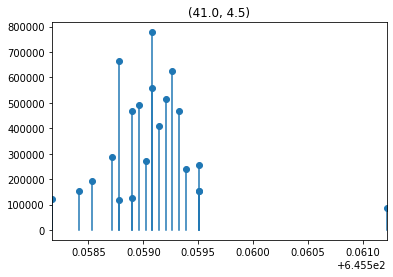

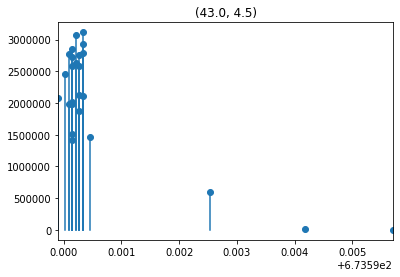

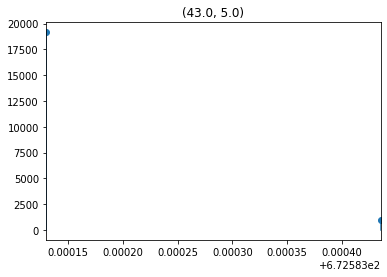

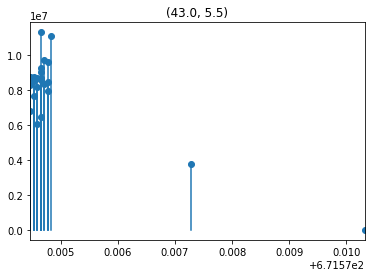

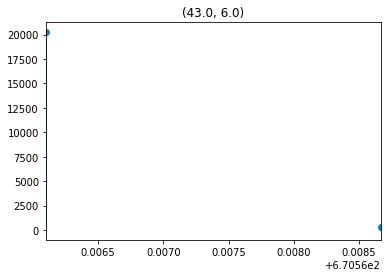

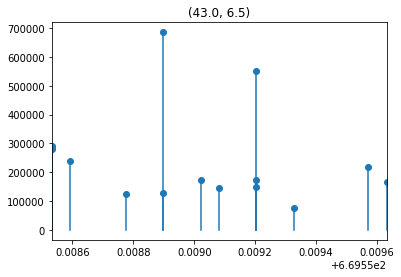

c:\Users\mirandaa\Desktop\lx128_p3\lipidxplorer\lx2\targets.py:138: UserWarning: Attempting to set identical left == right == 664.5203247070312 results in singular transformations; automatically expanding.
  plt.xlim([g_df[prefix+'m'].min(),g_df[prefix+'m'].max()])


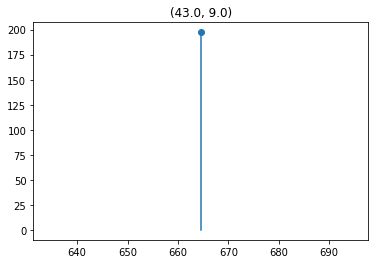

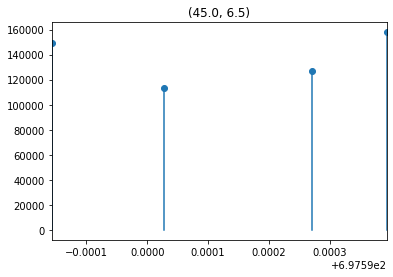

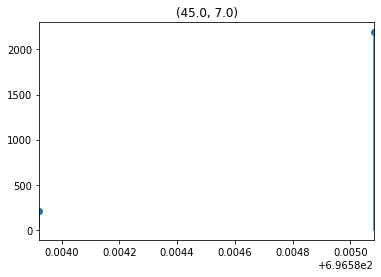

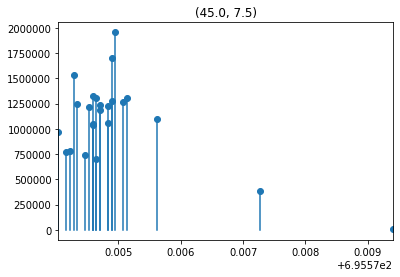

c:\Users\mirandaa\Desktop\lx128_p3\lipidxplorer\lx2\targets.py:138: UserWarning: Attempting to set identical left == right == 721.5938110351562 results in singular transformations; automatically expanding.
  plt.xlim([g_df[prefix+'m'].min(),g_df[prefix+'m'].max()])


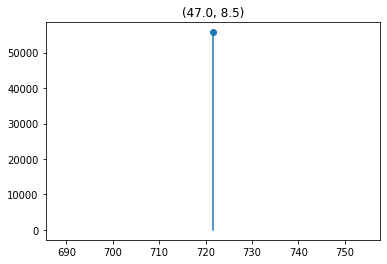

c:\Users\mirandaa\Desktop\lx128_p3\lipidxplorer\lx2\targets.py:138: UserWarning: Attempting to set identical left == right == 738.6293334960938 results in singular transformations; automatically expanding.
  plt.xlim([g_df[prefix+'m'].min(),g_df[prefix+'m'].max()])


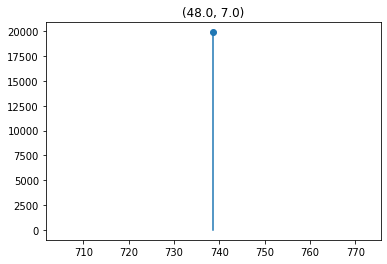

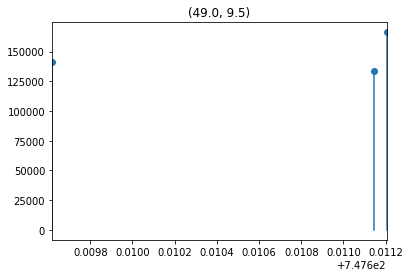

c:\Users\mirandaa\Desktop\lx128_p3\lipidxplorer\lx2\targets.py:138: UserWarning: Attempting to set identical left == right == 746.5982055664062 results in singular transformations; automatically expanding.
  plt.xlim([g_df[prefix+'m'].min(),g_df[prefix+'m'].max()])


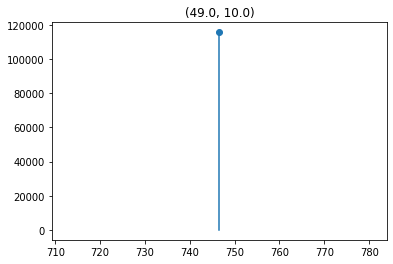

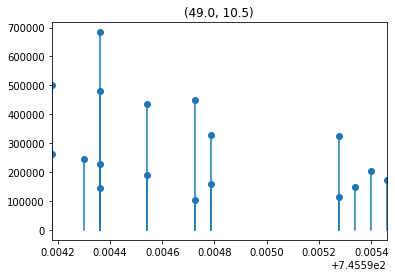

In [21]:
MFQL_util.showAll_lollipop(pr_df, sample = False)